# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

  335872/11490434 [..............................] - ETA: 1s

 5308416/11490434 [============>.................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 12:50 - loss: 0.6945

  26/1875 [..............................] - ETA: 3s - loss: 0.5632   

  56/1875 [..............................] - ETA: 3s - loss: 0.4736

  86/1875 [>.............................] - ETA: 3s - loss: 0.4283

 116/1875 [>.............................] - ETA: 3s - loss: 0.3999

 145/1875 [=>............................] - ETA: 3s - loss: 0.3802

 175/1875 [=>............................] - ETA: 2s - loss: 0.3642

 206/1875 [==>...........................] - ETA: 2s - loss: 0.3507

 237/1875 [==>...........................] - ETA: 2s - loss: 0.3395

 267/1875 [===>..........................] - ETA: 2s - loss: 0.3301

 297/1875 [===>..........................] - ETA: 2s - loss: 0.3218

 328/1875 [====>.........................] - ETA: 2s - loss: 0.3143

 358/1875 [====>.........................] - ETA: 2s - loss: 0.3077

 388/1875 [=====>........................] - ETA: 2s - loss: 0.3018

 419/1875 [=====>........................] - ETA: 2s - loss: 0.2962

 449/1875 [======>.......................] - ETA: 2s - loss: 0.2912

 477/1875 [======>.......................] - ETA: 2s - loss: 0.2869

 512/1875 [=======>......................] - ETA: 2s - loss: 0.2820

 546/1875 [=======>......................] - ETA: 2s - loss: 0.2775

 577/1875 [========>.....................] - ETA: 2s - loss: 0.2737

 611/1875 [========>.....................] - ETA: 2s - loss: 0.2698

 646/1875 [=========>....................] - ETA: 2s - loss: 0.2660

 673/1875 [=========>....................] - ETA: 1s - loss: 0.2633

 704/1875 [==========>...................] - ETA: 1s - loss: 0.2603

 735/1875 [==========>...................] - ETA: 1s - loss: 0.2574

 766/1875 [===========>..................] - ETA: 1s - loss: 0.2547

 797/1875 [===========>..................] - ETA: 1s - loss: 0.2522

 829/1875 [============>.................] - ETA: 1s - loss: 0.2496

 861/1875 [============>.................] - ETA: 1s - loss: 0.2472

 897/1875 [=============>................] - ETA: 1s - loss: 0.2446

 931/1875 [=============>................] - ETA: 1s - loss: 0.2423

 959/1875 [==============>...............] - ETA: 1s - loss: 0.2404

 989/1875 [==============>...............] - ETA: 1s - loss: 0.2385

1017/1875 [===============>..............] - ETA: 1s - loss: 0.2368

1048/1875 [===============>..............] - ETA: 1s - loss: 0.2350

1078/1875 [================>.............] - ETA: 1s - loss: 0.2332

1109/1875 [================>.............] - ETA: 1s - loss: 0.2315

1140/1875 [=================>............] - ETA: 1s - loss: 0.2299

1173/1875 [=================>............] - ETA: 1s - loss: 0.2282

1202/1875 [==================>...........] - ETA: 1s - loss: 0.2267

1233/1875 [==================>...........] - ETA: 1s - loss: 0.2252

1265/1875 [===================>..........] - ETA: 1s - loss: 0.2237

1296/1875 [===================>..........] - ETA: 0s - loss: 0.2223

1327/1875 [====================>.........] - ETA: 0s - loss: 0.2210

1359/1875 [====================>.........] - ETA: 0s - loss: 0.2196

1390/1875 [=====================>........] - ETA: 0s - loss: 0.2183

1421/1875 [=====================>........] - ETA: 0s - loss: 0.2170

1452/1875 [======================>.......] - ETA: 0s - loss: 0.2158

1484/1875 [======================>.......] - ETA: 0s - loss: 0.2146

1516/1875 [=======================>......] - ETA: 0s - loss: 0.2134

1548/1875 [=======================>......] - ETA: 0s - loss: 0.2122

1579/1875 [========================>.....] - ETA: 0s - loss: 0.2112

1611/1875 [========================>.....] - ETA: 0s - loss: 0.2100

1638/1875 [=========================>....] - ETA: 0s - loss: 0.2091

1668/1875 [=========================>....] - ETA: 0s - loss: 0.2082

1699/1875 [==========================>...] - ETA: 0s - loss: 0.2072

1731/1875 [==========================>...] - ETA: 0s - loss: 0.2061

1762/1875 [===========================>..] - ETA: 0s - loss: 0.2052

1793/1875 [===========================>..] - ETA: 0s - loss: 0.2043

1825/1875 [============================>.] - ETA: 0s - loss: 0.2033

1857/1875 [============================>.] - ETA: 0s - loss: 0.2024

1875/1875 [==============================] - 3s 2ms/step - loss: 0.2019


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1050

  32/1875 [..............................] - ETA: 2s - loss: 0.1099

  63/1875 [>.............................] - ETA: 2s - loss: 0.1098

  93/1875 [>.............................] - ETA: 2s - loss: 0.1097

 123/1875 [>.............................] - ETA: 2s - loss: 0.1096

 153/1875 [=>............................] - ETA: 2s - loss: 0.1095

 184/1875 [=>............................] - ETA: 2s - loss: 0.1094

 219/1875 [==>...........................] - ETA: 2s - loss: 0.1093

 252/1875 [===>..........................] - ETA: 2s - loss: 0.1092

 281/1875 [===>..........................] - ETA: 2s - loss: 0.1092

 310/1875 [===>..........................] - ETA: 2s - loss: 0.1091

 338/1875 [====>.........................] - ETA: 2s - loss: 0.1091

 373/1875 [====>.........................] - ETA: 2s - loss: 0.1090

 402/1875 [=====>........................] - ETA: 2s - loss: 0.1090

 431/1875 [=====>........................] - ETA: 2s - loss: 0.1089

 462/1875 [======>.......................] - ETA: 2s - loss: 0.1089

 494/1875 [======>.......................] - ETA: 2s - loss: 0.1088

 525/1875 [=======>......................] - ETA: 2s - loss: 0.1087

 554/1875 [=======>......................] - ETA: 2s - loss: 0.1087

 584/1875 [========>.....................] - ETA: 2s - loss: 0.1086

 615/1875 [========>.....................] - ETA: 2s - loss: 0.1085

 646/1875 [=========>....................] - ETA: 2s - loss: 0.1085

 677/1875 [=========>....................] - ETA: 1s - loss: 0.1084

 707/1875 [==========>...................] - ETA: 1s - loss: 0.1083

 737/1875 [==========>...................] - ETA: 1s - loss: 0.1083

 767/1875 [===========>..................] - ETA: 1s - loss: 0.1082

 798/1875 [===========>..................] - ETA: 1s - loss: 0.1081

 827/1875 [============>.................] - ETA: 1s - loss: 0.1081

 858/1875 [============>.................] - ETA: 1s - loss: 0.1080

 889/1875 [=============>................] - ETA: 1s - loss: 0.1079

 920/1875 [=============>................] - ETA: 1s - loss: 0.1079

 951/1875 [==============>...............] - ETA: 1s - loss: 0.1078

 982/1875 [==============>...............] - ETA: 1s - loss: 0.1077

1014/1875 [===============>..............] - ETA: 1s - loss: 0.1077

1043/1875 [===============>..............] - ETA: 1s - loss: 0.1076

1068/1875 [================>.............] - ETA: 1s - loss: 0.1075

1099/1875 [================>.............] - ETA: 1s - loss: 0.1075

1131/1875 [=================>............] - ETA: 1s - loss: 0.1074

1163/1875 [=================>............] - ETA: 1s - loss: 0.1073

1195/1875 [==================>...........] - ETA: 1s - loss: 0.1073

1224/1875 [==================>...........] - ETA: 1s - loss: 0.1072

1255/1875 [===================>..........] - ETA: 1s - loss: 0.1072

1286/1875 [===================>..........] - ETA: 0s - loss: 0.1071

1320/1875 [====================>.........] - ETA: 0s - loss: 0.1070

1356/1875 [====================>.........] - ETA: 0s - loss: 0.1070

1390/1875 [=====================>........] - ETA: 0s - loss: 0.1069

1422/1875 [=====================>........] - ETA: 0s - loss: 0.1068

1459/1875 [======================>.......] - ETA: 0s - loss: 0.1068

1486/1875 [======================>.......] - ETA: 0s - loss: 0.1067

1517/1875 [=======================>......] - ETA: 0s - loss: 0.1067

1549/1875 [=======================>......] - ETA: 0s - loss: 0.1066

1580/1875 [========================>.....] - ETA: 0s - loss: 0.1065

1611/1875 [========================>.....] - ETA: 0s - loss: 0.1065

1641/1875 [=========================>....] - ETA: 0s - loss: 0.1064

1672/1875 [=========================>....] - ETA: 0s - loss: 0.1064

1701/1875 [==========================>...] - ETA: 0s - loss: 0.1063

1734/1875 [==========================>...] - ETA: 0s - loss: 0.1063

1760/1875 [===========================>..] - ETA: 0s - loss: 0.1062

1796/1875 [===========================>..] - ETA: 0s - loss: 0.1062

1832/1875 [============================>.] - ETA: 0s - loss: 0.1061

1864/1875 [============================>.] - ETA: 0s - loss: 0.1061

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1060


Epoch 3/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0914

  31/1875 [..............................] - ETA: 3s - loss: 0.0986

  58/1875 [..............................] - ETA: 3s - loss: 0.0990

  87/1875 [>.............................] - ETA: 3s - loss: 0.0990

 118/1875 [>.............................] - ETA: 3s - loss: 0.0991

 150/1875 [=>............................] - ETA: 2s - loss: 0.0991

 182/1875 [=>............................] - ETA: 2s - loss: 0.0991

 213/1875 [==>...........................] - ETA: 2s - loss: 0.0991

 245/1875 [==>...........................] - ETA: 2s - loss: 0.0990

 276/1875 [===>..........................] - ETA: 2s - loss: 0.0990

 308/1875 [===>..........................] - ETA: 2s - loss: 0.0990

 340/1875 [====>.........................] - ETA: 2s - loss: 0.0989

 372/1875 [====>.........................] - ETA: 2s - loss: 0.0989

 404/1875 [=====>........................] - ETA: 2s - loss: 0.0988

 435/1875 [=====>........................] - ETA: 2s - loss: 0.0988

 467/1875 [======>.......................] - ETA: 2s - loss: 0.0988

 502/1875 [=======>......................] - ETA: 2s - loss: 0.0987

 538/1875 [=======>......................] - ETA: 2s - loss: 0.0987

 571/1875 [========>.....................] - ETA: 2s - loss: 0.0987

 604/1875 [========>.....................] - ETA: 2s - loss: 0.0986

 638/1875 [=========>....................] - ETA: 1s - loss: 0.0986

 676/1875 [=========>....................] - ETA: 1s - loss: 0.0986

 709/1875 [==========>...................] - ETA: 1s - loss: 0.0985

 741/1875 [==========>...................] - ETA: 1s - loss: 0.0985

 777/1875 [===========>..................] - ETA: 1s - loss: 0.0985

 815/1875 [============>.................] - ETA: 1s - loss: 0.0985

 846/1875 [============>.................] - ETA: 1s - loss: 0.0984

 876/1875 [=============>................] - ETA: 1s - loss: 0.0984

 904/1875 [=============>................] - ETA: 1s - loss: 0.0984

 934/1875 [=============>................] - ETA: 1s - loss: 0.0984

 963/1875 [==============>...............] - ETA: 1s - loss: 0.0984

 994/1875 [==============>...............] - ETA: 1s - loss: 0.0983

1021/1875 [===============>..............] - ETA: 1s - loss: 0.0983

1044/1875 [===============>..............] - ETA: 1s - loss: 0.0983

1071/1875 [================>.............] - ETA: 1s - loss: 0.0983

1100/1875 [================>.............] - ETA: 1s - loss: 0.0983

1121/1875 [================>.............] - ETA: 1s - loss: 0.0983

1146/1875 [=================>............] - ETA: 1s - loss: 0.0983

1171/1875 [=================>............] - ETA: 1s - loss: 0.0982

1192/1875 [==================>...........] - ETA: 1s - loss: 0.0982

1212/1875 [==================>...........] - ETA: 1s - loss: 0.0982

1236/1875 [==================>...........] - ETA: 1s - loss: 0.0982

1259/1875 [===================>..........] - ETA: 1s - loss: 0.0982

1281/1875 [===================>..........] - ETA: 1s - loss: 0.0982

1311/1875 [===================>..........] - ETA: 0s - loss: 0.0982

1337/1875 [====================>.........] - ETA: 0s - loss: 0.0982

1364/1875 [====================>.........] - ETA: 0s - loss: 0.0981

1395/1875 [=====================>........] - ETA: 0s - loss: 0.0981

1422/1875 [=====================>........] - ETA: 0s - loss: 0.0981

1449/1875 [======================>.......] - ETA: 0s - loss: 0.0981

1476/1875 [======================>.......] - ETA: 0s - loss: 0.0981

1498/1875 [======================>.......] - ETA: 0s - loss: 0.0981

1524/1875 [=======================>......] - ETA: 0s - loss: 0.0981

1556/1875 [=======================>......] - ETA: 0s - loss: 0.0980

1589/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1619/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1645/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1677/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1709/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1741/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1774/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1806/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1828/1875 [============================>.] - ETA: 0s - loss: 0.0979

1854/1875 [============================>.] - ETA: 0s - loss: 0.0979

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0979


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0850

  31/1875 [..............................] - ETA: 3s - loss: 0.0959

  64/1875 [>.............................] - ETA: 2s - loss: 0.0966

  95/1875 [>.............................] - ETA: 2s - loss: 0.0967

 126/1875 [=>............................] - ETA: 2s - loss: 0.0967

 149/1875 [=>............................] - ETA: 2s - loss: 0.0967

 175/1875 [=>............................] - ETA: 2s - loss: 0.0967

 205/1875 [==>...........................] - ETA: 2s - loss: 0.0966

 236/1875 [==>...........................] - ETA: 2s - loss: 0.0965

 267/1875 [===>..........................] - ETA: 2s - loss: 0.0965

 299/1875 [===>..........................] - ETA: 2s - loss: 0.0964

 330/1875 [====>.........................] - ETA: 2s - loss: 0.0964

 362/1875 [====>.........................] - ETA: 2s - loss: 0.0964

 393/1875 [=====>........................] - ETA: 2s - loss: 0.0964

 424/1875 [=====>........................] - ETA: 2s - loss: 0.0963

 454/1875 [======>.......................] - ETA: 2s - loss: 0.0963

 485/1875 [======>.......................] - ETA: 2s - loss: 0.0962

 516/1875 [=======>......................] - ETA: 2s - loss: 0.0962

 548/1875 [=======>......................] - ETA: 2s - loss: 0.0962

 580/1875 [========>.....................] - ETA: 2s - loss: 0.0962

 612/1875 [========>.....................] - ETA: 2s - loss: 0.0961

 639/1875 [=========>....................] - ETA: 2s - loss: 0.0961

 665/1875 [=========>....................] - ETA: 2s - loss: 0.0961

 693/1875 [==========>...................] - ETA: 1s - loss: 0.0961

 718/1875 [==========>...................] - ETA: 1s - loss: 0.0961

 750/1875 [===========>..................] - ETA: 1s - loss: 0.0961

 782/1875 [===========>..................] - ETA: 1s - loss: 0.0961

 814/1875 [============>.................] - ETA: 1s - loss: 0.0961

 846/1875 [============>.................] - ETA: 1s - loss: 0.0960

 879/1875 [=============>................] - ETA: 1s - loss: 0.0960

 911/1875 [=============>................] - ETA: 1s - loss: 0.0960

 943/1875 [==============>...............] - ETA: 1s - loss: 0.0960

 974/1875 [==============>...............] - ETA: 1s - loss: 0.0960

1005/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1037/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1069/1875 [================>.............] - ETA: 1s - loss: 0.0960

1101/1875 [================>.............] - ETA: 1s - loss: 0.0960

1133/1875 [=================>............] - ETA: 1s - loss: 0.0960

1166/1875 [=================>............] - ETA: 1s - loss: 0.0960

1192/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1219/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1247/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1275/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1297/1875 [===================>..........] - ETA: 0s - loss: 0.0960

1325/1875 [====================>.........] - ETA: 0s - loss: 0.0960

1350/1875 [====================>.........] - ETA: 0s - loss: 0.0960

1376/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1401/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1427/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1453/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1475/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1502/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1528/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1550/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1577/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1606/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1633/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1662/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1692/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1720/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1751/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1783/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1814/1875 [============================>.] - ETA: 0s - loss: 0.0959

1846/1875 [============================>.] - ETA: 0s - loss: 0.0959

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0959


Epoch 5/5


   1/1875 [..............................] - ETA: 4s - loss: 0.0986

  33/1875 [..............................] - ETA: 2s - loss: 0.0960

  64/1875 [>.............................] - ETA: 2s - loss: 0.0957

  95/1875 [>.............................] - ETA: 2s - loss: 0.0956

 126/1875 [=>............................] - ETA: 2s - loss: 0.0955

 158/1875 [=>............................] - ETA: 2s - loss: 0.0955

 181/1875 [=>............................] - ETA: 2s - loss: 0.0954

 208/1875 [==>...........................] - ETA: 2s - loss: 0.0954

 240/1875 [==>...........................] - ETA: 2s - loss: 0.0954

 263/1875 [===>..........................] - ETA: 2s - loss: 0.0953

 288/1875 [===>..........................] - ETA: 2s - loss: 0.0953

 313/1875 [====>.........................] - ETA: 2s - loss: 0.0953

 345/1875 [====>.........................] - ETA: 2s - loss: 0.0953

 377/1875 [=====>........................] - ETA: 2s - loss: 0.0953

 409/1875 [=====>........................] - ETA: 2s - loss: 0.0953

 441/1875 [======>.......................] - ETA: 2s - loss: 0.0953

 472/1875 [======>.......................] - ETA: 2s - loss: 0.0953

 504/1875 [=======>......................] - ETA: 2s - loss: 0.0953

 536/1875 [=======>......................] - ETA: 2s - loss: 0.0953

 568/1875 [========>.....................] - ETA: 2s - loss: 0.0953

 600/1875 [========>.....................] - ETA: 2s - loss: 0.0953

 632/1875 [=========>....................] - ETA: 2s - loss: 0.0953

 664/1875 [=========>....................] - ETA: 2s - loss: 0.0953

 695/1875 [==========>...................] - ETA: 1s - loss: 0.0952

 727/1875 [==========>...................] - ETA: 1s - loss: 0.0952

 759/1875 [===========>..................] - ETA: 1s - loss: 0.0952

 790/1875 [===========>..................] - ETA: 1s - loss: 0.0952

 822/1875 [============>.................] - ETA: 1s - loss: 0.0952

 853/1875 [============>.................] - ETA: 1s - loss: 0.0952

 885/1875 [=============>................] - ETA: 1s - loss: 0.0952

 917/1875 [=============>................] - ETA: 1s - loss: 0.0952

 949/1875 [==============>...............] - ETA: 1s - loss: 0.0952

 981/1875 [==============>...............] - ETA: 1s - loss: 0.0952

1014/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1046/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1068/1875 [================>.............] - ETA: 1s - loss: 0.0952

1092/1875 [================>.............] - ETA: 1s - loss: 0.0952

1123/1875 [================>.............] - ETA: 1s - loss: 0.0952

1154/1875 [=================>............] - ETA: 1s - loss: 0.0952

1186/1875 [=================>............] - ETA: 1s - loss: 0.0952

1218/1875 [==================>...........] - ETA: 1s - loss: 0.0952

1250/1875 [===================>..........] - ETA: 1s - loss: 0.0952

1281/1875 [===================>..........] - ETA: 0s - loss: 0.0952

1310/1875 [===================>..........] - ETA: 0s - loss: 0.0952

1338/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1368/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1396/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1421/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1453/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1485/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1517/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1549/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1581/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1613/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1645/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1677/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1709/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1741/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1768/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1823/1875 [============================>.] - ETA: 0s - loss: 0.0952

1854/1875 [============================>.] - ETA: 0s - loss: 0.0952

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0952


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

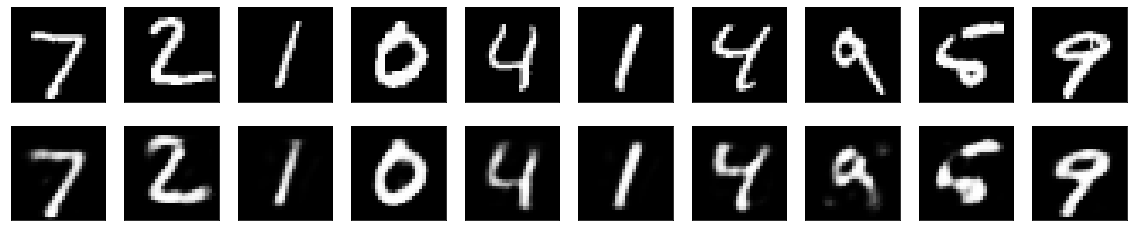

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
